In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Creating frames

fh = '/Users/henrycosentino/Desktop/Python/Projects/Dynamic Beta/beta_data_pulls.xlsx'
sheet_names = ['ETF Values', 'Utilties Values', 'Tech Values', 'Disc Values', 'Staples Values']

df_dict = {}

for sheet in sheet_names:
    df = pd.read_excel(fh, sheet_name=sheet)
    df_dict[sheet] = df

etf_df, utilties_df, tech_df, disc_df, staples_df = [df_dict[sheet] for sheet in sheet_names]
frames = [etf_df, utilties_df, tech_df, disc_df, staples_df]
sector_frames = [utilties_df, tech_df, disc_df, staples_df]

In [3]:
etf_df

,Date,SPY US Equity,Date.1,VPU US Equity,Date.2,VGT US Equity,Date.3,VCR US Equity,Date.4,VDC US Equity
0,2019-10-14,295.95,2019-10-14,140.89,2019-10-14,218.49,2019-10-14,180.0700,2019-10-14,154.08
1,2019-10-15,298.88,2019-10-15,140.42,2019-10-15,220.76,2019-10-15,181.8100,2019-10-15,153.52
2,2019-10-16,298.40,2019-10-16,140.82,2019-10-16,218.83,2019-10-16,182.6400,2019-10-16,153.50
3,2019-10-17,299.28,2019-10-17,141.23,2019-10-17,218.62,2019-10-17,183.3600,2019-10-17,154.34
4,2019-10-18,297.97,2019-10-18,141.72,2019-10-18,216.31,2019-10-18,182.5900,2019-10-18,154.53
...,...,...,...,...,...,...,...,...,...,...
1253,2024-10-07,567.80,2024-10-07,171.01,2024-10-07,580.84,2024-10-07,331.2300,2024-10-07,212.83
1254,2024-10-08,573.17,2024-10-08,171.06,2024-10-08,591.43,2024-10-08,333.8100,2024-10-08,214.08
1255,2024-10-09,577.14,2024-10-09,169.67,2024-10-09,598.05,2024-10-09,335.5200,2024-10-09,215.41
1256,2024-10-10,576.13,2024-10-10,169.15,2024-10-10,598.59,2024-10-10,334.3900,2024-10-10,214.44


In [4]:
# Calculating daily price returns in ALL frames

for frame in frames:
    for col in frame.columns:
        if 'US' in col:
            frame[col] = (frame[col] / frame[col].shift(1) - 1)
    frame.drop(df.index[0], inplace=True)

In [5]:
# Doing some preliminary data clean up

etf_df.set_index(etf_df['Date'], inplace=True)
etf_df = etf_df.drop(columns=[col for col in etf_df.columns if col.startswith('Date')])
etf_df.rename(columns={
    "SPY US Equity": "S&P 500", 
    "VPU US Equity": "Utilities Sector",
    "VGT US Equity": "Technology Sector", 
    "VCR US Equity": "Discretionary Sector",
    "VDC US Equity": "Staples Sector"
}, inplace=True)
etf_df.head()

,S&P 500,Utilities Sector,Technology Sector,Discretionary Sector,Staples Sector
Date,,,,,
2019-10-15,0.009900,-0.003336,0.010389,0.009663,-0.003634
2019-10-16,-0.001606,0.002849,-0.008743,0.004565,-0.000130
2019-10-17,0.002949,0.002912,-0.000960,0.003942,0.005472
2019-10-18,-0.004377,0.003470,-0.010566,-0.004199,0.001231
2019-10-21,0.006779,0.003458,0.010032,0.004655,0.003171


In [6]:
# Creating statistical functions

def calculate_beta(market_return, asset_return):
    covariance = asset_return.cov(market_return)
    variance = market_return.var()
    return covariance / variance

def rolling_betas(frame, market, window_size, min_period):
    return frame.rolling(window_size, min_periods=min_period).apply(
        lambda x: calculate_beta(frame[market].loc[x.index], x),
        raw=False
    )

def beta_for_frame(frame, market):
    betas = {}
    for asset in frame.columns:
        betas[asset] = calculate_beta(frame[market], frame[asset])
    return pd.Series(betas)

def rolling_corr(frame, market, window_size, min_period):
    return frame.rolling(window_size, min_periods=min_period).apply(
        lambda x: (frame[market].loc[x.index].corr(x)),
        raw=False
    )

def corr_for_frame(frame, market):
    r_squared = {}
    for asset in frame.columns:
        r_squared[asset] = (frame[market].corr(frame[asset]))
    return pd.Series(r_squared)

In [7]:
# Starting with sector level data exploration

sector_roll_beta_df = rolling_betas(etf_df, 'S&P 500', 70, 70)
sector_beta_df = beta_for_frame(etf_df, 'S&P 500').sort_values(ascending=False)
sector_roll_corr_df = rolling_corr(etf_df,'S&P 500', 70, 70)
sector_corr_df = corr_for_frame(etf_df, 'S&P 500').sort_values(ascending=False)

print("\033[1mAVERAGE 70 DAY ROLLING BETA:\033[0m\n", sector_roll_beta_df.mean().sort_values(ascending=False), "\n")
print("\033[1mTOTAL BETA:\033[0m\n", sector_beta_df, "\n")
print("\033[1mAVERAGE 70 DAY ROLLING CORRELATION:\033[0m\n", sector_roll_corr_df.mean().sort_values(ascending=False), "\n")
print("\033[1mTOTAL CORRELATION:\033[0m\n", sector_corr_df)

AVERAGE 70 DAY ROLLING BETA:
 Technology Sector       1.316831
Discretionary Sector    1.181555
S&P 500                 1.000000
Utilities Sector        0.551226
Staples Sector          0.522956
dtype: float64 

TOTAL BETA:
 Technology Sector       1.234916
Discretionary Sector    1.118766
S&P 500                 1.000000
Utilities Sector        0.741249
Staples Sector          0.628931
dtype: float64 

AVERAGE 70 DAY ROLLING CORRELATION:
 S&P 500                 1.000000
Technology Sector       0.908027
Discretionary Sector    0.872420
Staples Sector          0.657240
Utilities Sector        0.496329
dtype: float64 

TOTAL CORRELATION:
 S&P 500                 1.000000
Technology Sector       0.930936
Discretionary Sector    0.897816
Staples Sector          0.783580
Utilities Sector        0.672869
dtype: float64


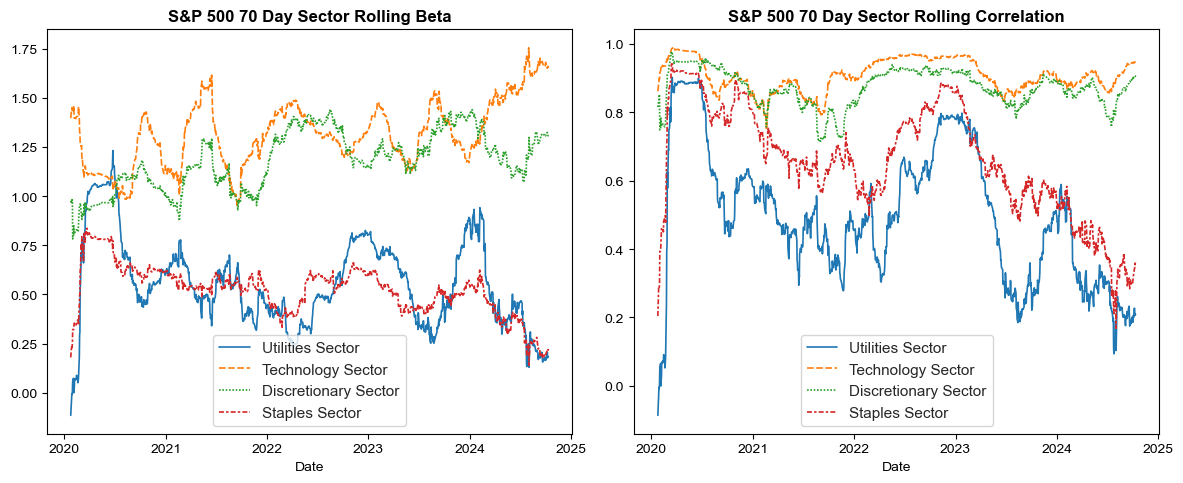

In [19]:
# Visualizing Rolling Beta & Correlation Data

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.set_theme(style="ticks")
sns.lineplot(data=sector_roll_beta_df.drop(columns='S&P 500'), palette="tab10", linewidth=1.2, 
             ax=axes[0]).set_title("S&P 500 70 Day Sector Rolling Beta", fontweight='bold')
sns.lineplot(data=sector_roll_corr_df.drop(columns='S&P 500'), palette="tab10", linewidth=1.2, 
             ax=axes[1]).set_title("S&P 500 70 Day Sector Rolling Correlation", fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
# Data frame cleaner for date columns

def date_frame_cleaner(frame):
    frame.set_index(frame['Date'], inplace=True)
    frame.drop(columns=[col for col in frame.columns if col.startswith('Date')], inplace=True)
    return frame

utilties_df, tech_df, disc_df, staples_df = [date_frame_cleaner(frame) for frame in sector_frames]

## UTILTIES BETA ANALYSIS

- SO MKT CAP = 98.23BN
- CWT MKT CAP = 3.13BN
- EIX MKT CAP = 32.65BN

In [11]:
# Moving on to equity level data exploration and research

utilties_df_join = utilties_df.join(etf_df[['S&P 500','Utilities Sector']])
utilties_roll_beta_df = rolling_betas(utilties_df_join, 'S&P 500', 70, 70)

print("\033[1mUTILITIES AVERAGE 70 DAY ROLLING BETA:\033[0m\n", utilties_roll_beta_df.mean().sort_values(ascending=False), "\n")
print("\033[1mUTILITIES TOTAL BETA:\033[0m\n", beta_for_frame(utilties_df_join,'S&P 500' ))

UTILITIES AVERAGE 70 DAY ROLLING BETA:
 S&P 500             1.000000
CWT US              0.605903
EIX US              0.587996
Utilities Sector    0.551226
SO US               0.446031
dtype: float64 

UTILITIES TOTAL BETA:
 SO US               0.712222
CWT US              0.717367
EIX US              0.793099
S&P 500             1.000000
Utilities Sector    0.741249
dtype: float64


Text(0.5, 1.0, 'Utility Stocks Rolling Beta to S&P 500')

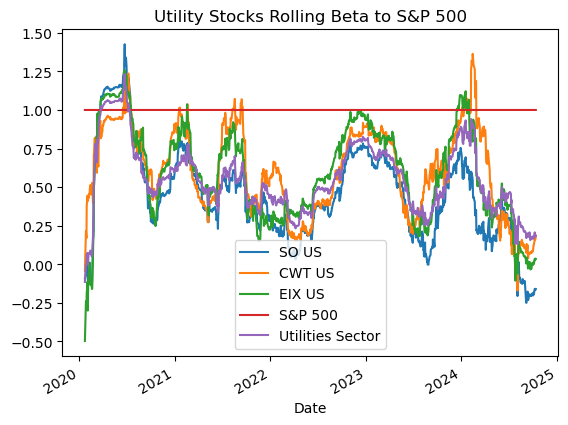

In [12]:
utilties_roll_beta_df.plot().set_title("Utility Stocks Rolling Beta to S&P 500")

## STAPLES BETA ANALYSIS

- SMPL MKT CAP = 3.42BN
- MNST MKT CAP = 50.62BN
- COST MKT CAP = 394.23BN

In [13]:
staples_df_join = staples_df.join(etf_df[['S&P 500','Staples Sector']])
staples_roll_beta_df = rolling_betas(staples_df_join, 'S&P 500', 70, 70)

print("\033[1mSTAPLES AVERAGE 70 DAY ROLLING BETA:\033[0m\n", staples_roll_beta_df.mean().sort_values(ascending=False), "\n")
print("\033[1mSTAPLES TOTAL BETA:\033[0m\n", beta_for_frame(staples_df_join,'S&P 500' ))

STAPLES AVERAGE 70 DAY ROLLING BETA:
 S&P 500           1.000000
SMPL US           0.830559
MNST US           0.759691
COST US           0.750779
Staples Sector    0.522956
dtype: float64 

STAPLES TOTAL BETA:
 COST US           0.727351
MNST US           0.821684
SMPL US           0.869425
S&P 500           1.000000
Staples Sector    0.628931
dtype: float64


Text(0.5, 1.0, 'Staple Stocks Rolling Beta to S&P 500')

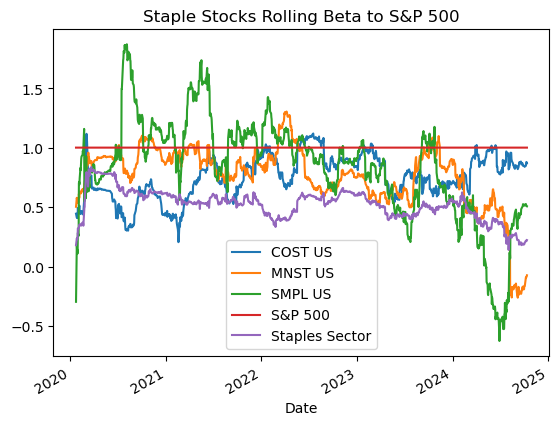

In [14]:
staples_roll_beta_df.plot().set_title("Staple Stocks Rolling Beta to S&P 500")

## DISCRETIONARY BETA ANALYSIS

- AMZN MKT CAP = 1.97T
- PZZA MKT CAP = 1.62BN
- FIVE MKT CAP = 4.98BN

In [15]:
disc_df_join = disc_df.join(etf_df[['S&P 500','Discretionary Sector']])
discretionary_roll_beta_df = rolling_betas(disc_df_join, 'S&P 500', 70, 70)

print("\033[1mDISCRETIONARY AVERAGE 70 DAY ROLLING BETA:\033[0m\n", discretionary_roll_beta_df.mean().sort_values(ascending=False), "\n")
print("\033[1mDISCRETIONARY TOTAL BETA:\033[0m\n", beta_for_frame(disc_df_join,'S&P 500' ))

DISCRETIONARY AVERAGE 70 DAY ROLLING BETA:
 AMZN US                 1.285543
FIVE US                 1.223402
Discretionary Sector    1.181555
S&P 500                 1.000000
PZZA US                 0.752380
dtype: float64 

DISCRETIONARY TOTAL BETA:
 AMZN US                 1.090735
FIVE US                 1.381768
PZZA US                 0.745820
S&P 500                 1.000000
Discretionary Sector    1.118766
dtype: float64


Text(0.5, 1.0, 'Discretionary Stocks Rolling Beta to S&P 500')

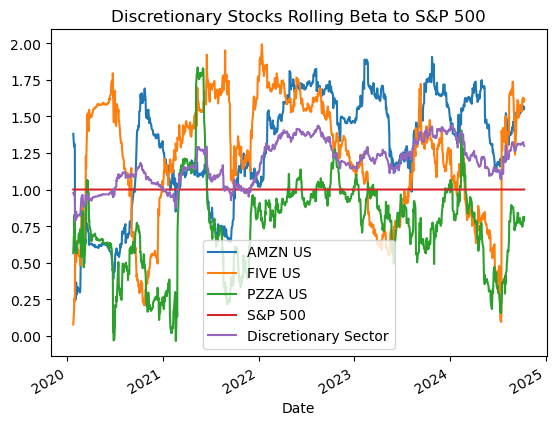

In [16]:
discretionary_roll_beta_df.plot().set_title("Discretionary Stocks Rolling Beta to S&P 500")

## TECHNOLOGY BETA ANALYSIS

- ACMR MKT CAP = 1.20BN
- AMAT MKT CAP = 153.64BN
- ENPH MKT CAP = 12.41BN

In [17]:
tech_df_join = tech_df.join(etf_df[['S&P 500','Technology Sector']])
technology_roll_beta_df = rolling_betas(tech_df_join, 'S&P 500', 70, 70)

print("\033[1mTECHNOLOGY AVERAGE 70 DAY ROLLING BETA:\033[0m\n", technology_roll_beta_df.mean().sort_values(ascending=False), "\n")
print("\033[1mTECHNOLOGY TOTAL BETA:\033[0m\n", beta_for_frame(tech_df_join,'S&P 500' ))

TECHNOLOGY AVERAGE 70 DAY ROLLING BETA:
 ACMR US              2.162726
AMAT US              1.799493
ENPH US              1.760862
Technology Sector    1.316831
S&P 500              1.000000
dtype: float64 

TECHNOLOGY TOTAL BETA:
 AMAT US              1.658203
ACMR US              1.743521
ENPH US              1.640218
S&P 500              1.000000
Technology Sector    1.234916
dtype: float64


Text(0.5, 1.0, 'Technology Stocks Rolling Beta to S&P 500')

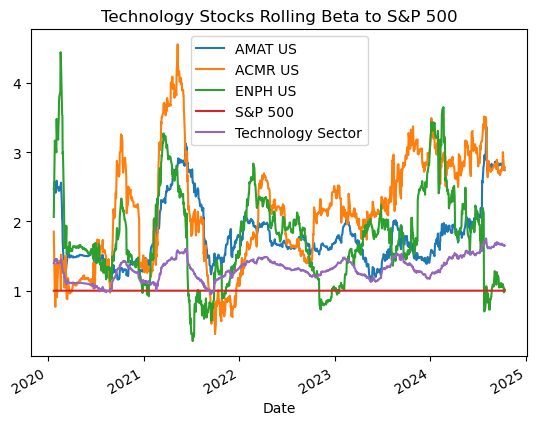

In [18]:
technology_roll_beta_df.plot().set_title("Technology Stocks Rolling Beta to S&P 500")

## NEXT STEPS
- Look at returns from different periods: high/low beta periods converging to mean, and divergence from mean to high/low beta
- Look at returns from different earning periods